## Predicting Survival on Titanic - Kaggle Competition
After looking around for inspiration from fellow kagglers, i gained some great insights about the Titanic dataset. I noticed Random Forest Trees to be the go-to technique for prediction in this competition. Having python at my disposal, i figured i am interested in attempting multiple ML techniques and hope to analyze how they fare. 

## Project Plan: 
![img](https://github.com/PrathyushaSangam/DataScienceUsingPython/blob/master/Images/DataScience%20Proj%20Lifecycle.png?raw=true)

***Reference: Zumel, N. and Mount, J. (2014). Practical data science with R. Shelter Island, NY: Manning Publications Co., p.6.***

This image I saw on the first day school, showing how a Data Science Project Lifecycle works, really stuck around. It shows what questions we need to address, how we may go back and forth in various stages. It's a good starting point for anyone, to lay out a project plan.

** How do we go ahead? **  
* Define the objective
* Set up helpful functions
* Load data
* Perform preliminary analysis on what we have
* Try digging deeper - finding correlations, importance of variables
* Data Cleaning - dealing with missing values
* Feature Engineering / Extraction - creation and convertion
* Dropping unfixable/unimportant features
* Modelling using multiple ML techniques
* Evaluation

## Objective:
1.	Analysing the Titanic dataset to obtain useful and interesting insights.
2.	Predicting survival on the Titanic using multiple ML techniques.

## Setting up libraries and functions

In [6]:
# Data Analysis
import numpy as np 
import pandas as pd

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# allowing multiple/scrollable outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#machine Learning

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from fancyimpute import KNN


In [7]:
#Setting up functions for visualization

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( plt.hist , var , alpha=0.5)
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
# Function inspired by Helge Bjorland: An Interactive Data Science Tutorial

## Load Data
We create a combined list of dataframes - df_full, to allow us perform operations both datasets require at once, using a simple for loop.

In [8]:
# Load data
df_train = pd.read_csv('Datasets/titanic_train.csv')
df_test = pd.read_csv('Datasets/titanic_test.csv')

df_full = [df_train, df_test]

## Preliminary/Descriptive Analysis 
Now that we have our data ready, we can look at the variables, shape of the data, missing values and some standard descriptive stats. Further, we can figure out sensible data cleaning and possible feature extraction/engineering opportunities.


In [9]:
# preliminary analysis
print('Shape of the Data -> Train:', df_train.shape, 'Test:', df_test.shape)
pd.crosstab(index = df_train['Survived'], columns = "count")

Shape of the Data -> Train: (891, 12) Test: (418, 11)


col_0,count
Survived,
0,549
1,342


In [10]:
# preliminary analysis
df_train.describe()
df_train.isnull().sum()
df_test.isnull().sum()

#for understanding datatypes of columns
#df_train.info()
#df_test.info()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### What we know so far:
* Train has 891 records, Test has 418 records, amounting to a total of 1309. The original passenger count on Titanic was 2208. So we can say we have 59.3% of data for this competition.

*  From our dataset, we see 38.3% chance of survival (Positive samples of Survival: 342 , negative samples: 549). On the Titanic, 705/2208 passengers survived i.e., 32% survived.

* Missing values - both datasets: Age - 263 (~20%), Cabin - 1014 (~77%) , Embarked- 2, Fare- 1. The missing values of Age, Fare and Embarked might be important in deciding the survival of a passenger, hence have to be filled. Though we can assume that Cabin might have been an important variable, defining the closeness to a lifeboat; with almost 77% missingness, this feature can be dropped.
Note: NaN in Survived column of df_full (in last 418 records) are added due to coercion, since df_test has no Survived column

*  Mean age of the passengers is 29.68 and ranges between 0.42 - 80 years

* There is a large variation in fare, someone (or some people) travelled for free (\$0), the mean of fare is \$32.20, ranging upto a costly \$512.33.

* Names have titles, which describe their social status, sometimes age, marital status in women and even occupation! (Royalty, Mr, Dr, Master, Mrs and so on.) which might have some correlation with survival rates. However, names can be dropped while retaining the title.

## Digging Deeper - Finding correlations and variable importance

* Using Cross-tabulation/ frequency tables and visualizations, we can look at correlations among the features and also guage their importance in predicting survival. 

* High School Math Rocks: Since survival is binary (0/1), the mean of survived directly gives probability of survival in any given category! We can use this simple calculation to check the chance of survival given sex, pclass, embarkation etc.


### Categorical Variables : Pclass, Family Size (SibSp & Parch), Embarked vs Survival

In [11]:
table1 = pd.pivot_table(df_train, values='Survived', index=['Pclass'])
table1

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [12]:
for dataset in df_full:
    family_size = dataset.SibSp + dataset.Parch +1 #including themselves
    dataset['FamilySize'] = family_size


table2 = pd.pivot_table(df_train, values = 'Survived', index= ['FamilySize'])
table2

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


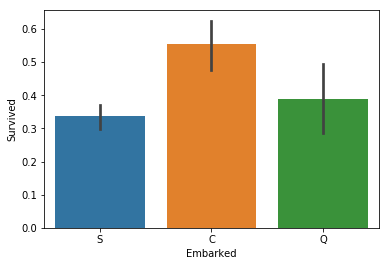

In [13]:
sns.barplot(x=df_train['Embarked'],y=df_train['Survived'] )

### Findings:
* Women and passengers from higher classes had a better chance of survival.
* Women in Pclass 3 had lower survival rates than Pclass 1 and 2, which are above 90%. Men from Pclass 1 had slightly better survival rates than men in other classes.
* Having family members improves survival than those travelling alone. On the contrary bigger familes sink together!
* Passengers who embarked in C=Cherbourg had more chance of survival, followed by Q=Queenstown

### Continuous Variables: Age, Fare vs Survival

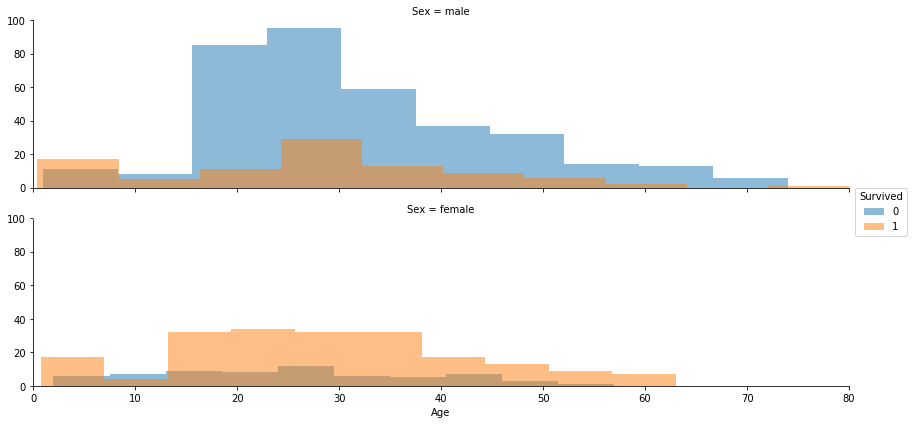

In [14]:
plot_distribution( df_train , var = 'Age' , target = 'Survived', row = 'Sex')

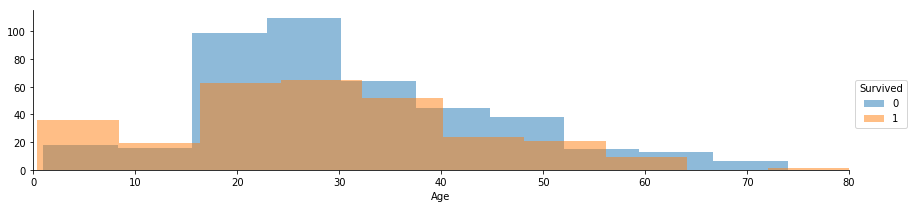

In [15]:
plot_distribution( df_train , var = 'Age' , target = 'Survived')

In [16]:
child = df_train[(df_train['Age']<=10)]
pd.pivot_table(child, index = ['Sex'], values = 'Survived')

,Survived
Sex,
female,0.612903
male,0.575758


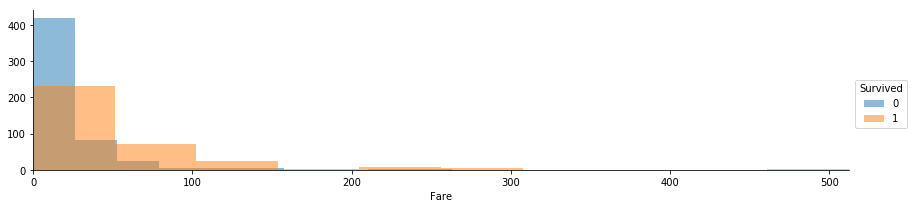

In [17]:
plot_distribution( df_train , var = 'Fare' , target = 'Survived')

### Findings
* Among males,  57.6% children age <=10 survived. The survival rate got lower as age increased, with an exception of age 80.
* Among females, 61.2% children age <=10 survived, whereas, women in general had a good chance of survival.
* Overall, children had better survival rates than adults
*  Passengers who paid more fare had better chance of survival.

### Decisions
Age and Fare are continuous variables. These variables can be converted into categorical / ordinals by diving them into bands and assigning each band an ordinal value.


## Feature Extraction and Data Cleaning 

**Missingness**
* Filling missing Embarked in df_train: with most common port of embarkation
* Filling missing fare df_test: with the median fare
* Filling Missing Age : using KNN. lets push this task to post feature extraction, title could help with filling missing age.

**Features to numeric**
* Converting Sex to numeric (male:0 female:1)
* Converting Embarked to numeric (S:0, C:1, Q:2)

**Binning FamilySize**
 * FamilySize =1 | alone|  ordinal =0
 * FamilySize >1 and < 4 | small family | ordinal =1
 * FamilySize >4 | Large Family | ordinal = 2
 
** Binning: Age bands and Fare bands**
* Age: Ordinal age bands - By dividing age into 5 age groups
* Fare: Ordinal fare bands - By dividing into 4 groups based on quantiles

** Extracting new features**
 * **Title** counting number of titles in entire dataset (both test and train, since both need cleaning) , replacing rare titles and synonymous titles, giving category number to each title

**Dropping columns**
* Ticket
* PassengerId
* Name
* Cabin

In [18]:
#missing Embarked
port_mode = df_train.Embarked.mode()[0]
#port_mode
df_train['Embarked'] = df_train['Embarked'].fillna(port_mode)

#missing Fare
fare_median = df_test.Fare.median()
#fare_median
df_test['Fare'] = df_test['Fare'].fillna(fare_median)

In [19]:
#numeric values for Sex
for dataset in df_full:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [20]:
#numeric values to Embarked
for dataset in df_full:
    dataset['Embarked'] = dataset['Embarked'].map({'S':0 , 'C':1 , 'Q':2}).astype(int)

In [21]:
# Grouping Family Size to Ordinals
for dataset in df_full:
    dataset['FamilySize'] = dataset['FamilySize'].replace([1], 0)
    dataset['FamilySize'] = dataset['FamilySize'].replace([2,3,4], 1)
    dataset['FamilySize'] = dataset['FamilySize'].replace([5,6,7,8,9,10,11], 2)

pd.pivot_table(df_train, index = 'FamilySize' , values= 'Survived')

,Survived
FamilySize,
0,0.303538
1,0.578767
2,0.161290


In [22]:
#quantiles for fare attribute
pd.qcut(df_train['Fare'],4, retbins=True)[1]

array([  0.    ,   7.9104,  14.4542,  31.    , 512.3292])

In [23]:
#creating same bins for fare bands in train and test based on quantiles in train
#giving ordinal labels 0-3

bins = [0,7.91,14.454,31.0,513.0]
labels = [0,1,2,3]

for dataset in df_full:
    dataset['Fareband'] = pd.cut(dataset['Fare'], bins=bins, labels=labels, include_lowest = True)
    dataset['Fareband'] = dataset['Fareband'].astype(int)

pd.pivot_table(df_train, index = df_train['Fareband'],values = 'Survived' )

,Survived
Fareband,
0,0.197309
1,0.308756
2,0.445415
3,0.581081


In [24]:
for dataset in df_full:
 dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [25]:
# to get an idea of all titles in both datasets (to make cleaning easier)
all_titles = df_test['Title'].append(df_train['Title'])
pd.crosstab(all_titles,'count')

col_0,count
Title,
Capt,1
Col,4
Countess,1
Don,1
Dona,1
Dr,8
Jonkheer,1
Lady,1
Major,2


In [26]:
for dataset in df_full:
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'],'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme'], 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Capt','Col','Don','Jonkheer','Major','Sir','Rev','Dr'],'Raremale')
    dataset['Title'] = dataset['Title'].replace(['Countess','Dona','Lady'],'Rarefemale')

In [27]:
pd.pivot_table(df_train, index = df_train['Title'], values = 'Survived')

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rarefemale,1.000000
Raremale,0.285714


In [28]:
title_map = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rarefemale":5, "Raremale":6}
for dataset in df_full:
    dataset['Title'] = dataset['Title'].map(title_map)
    

In [29]:
df_train.head()
df_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Fareband,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,3,4
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,3,4
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,1,3


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Fareband,Title
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,2,0,0,3
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,1,0,4
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,2,0,1,3
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0,0,1,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0,1,1,4


### Fill in missing age, creating age bands, mapping age bands to ordinals


In [30]:
#dropping columns which we may not need / use
for dataset in df_full:
    dataset.drop(['Name','SibSp','Parch','Ticket','Cabin','Fare'], axis= 1, inplace = True)

In [31]:
#dataframes we are left with : age still has missing values
df_train.head()
df_test.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,FamilySize,Fareband,Title
0,1,0,3,0,22.0,0,1,0,3
1,2,1,1,1,38.0,1,1,3,4
2,3,1,3,1,26.0,0,0,1,2
3,4,1,1,1,35.0,0,1,3,4
4,5,0,3,0,35.0,0,0,1,3


,PassengerId,Pclass,Sex,Age,Embarked,FamilySize,Fareband,Title
0,892,3,0,34.5,2,0,0,3
1,893,3,1,47.0,0,1,0,4
2,894,2,0,62.0,2,0,1,3
3,895,3,0,27.0,0,0,1,3
4,896,3,1,22.0,0,1,1,4


In [32]:
#impute age in df_train and df_test
for dataset in df_full:
    new_df = dataset[['PassengerId','Pclass','Sex','Age','Embarked','FamilySize','Fareband','Title']]
    filled = KNN(k=3).complete(new_df)
    filled = pd.DataFrame(filled, columns =['PassengerId','Pclass','Sex','Age','Embarked','FamilySize','Fareband','Title'])
#separate modifying original dataframe, add histograms for comparison
    dataset['Age'] = filled['Age']
    dataset.head()
    dataset.isnull().sum()


Imputing row 1/891 with 0 missing, elapsed time: 0.239
Imputing row 101/891 with 0 missing, elapsed time: 0.244
Imputing row 201/891 with 0 missing, elapsed time: 0.245
Imputing row 301/891 with 1 missing, elapsed time: 0.247
Imputing row 401/891 with 0 missing, elapsed time: 0.249
Imputing row 501/891 with 0 missing, elapsed time: 0.250
Imputing row 601/891 with 0 missing, elapsed time: 0.251
Imputing row 701/891 with 0 missing, elapsed time: 0.252
Imputing row 801/891 with 0 missing, elapsed time: 0.253


,PassengerId,Survived,Pclass,Sex,Age,Embarked,FamilySize,Fareband,Title
0,1,0,3,0,22.0,0,1,0,3
1,2,1,1,1,38.0,1,1,3,4
2,3,1,3,1,26.0,0,0,1,2
3,4,1,1,1,35.0,0,1,3,4
4,5,0,3,0,35.0,0,0,1,3


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Embarked       0
FamilySize     0
Fareband       0
Title          0
dtype: int64

Imputing row 1/418 with 0 missing, elapsed time: 0.052
Imputing row 101/418 with 0 missing, elapsed time: 0.054
Imputing row 201/418 with 1 missing, elapsed time: 0.055
Imputing row 301/418 with 0 missing, elapsed time: 0.058
Imputing row 401/418 with 0 missing, elapsed time: 0.060


,PassengerId,Pclass,Sex,Age,Embarked,FamilySize,Fareband,Title
0,892,3,0,34.5,2,0,0,3
1,893,3,1,47.0,0,1,0,4
2,894,2,0,62.0,2,0,1,3
3,895,3,0,27.0,0,0,1,3
4,896,3,1,22.0,0,1,1,4


PassengerId    0
Pclass         0
Sex            0
Age            0
Embarked       0
FamilySize     0
Fareband       0
Title          0
dtype: int64

In [33]:
#hist before and after imputation
#plt.hist(filled['Age'],bins=10, alpha=0.5)
#plt.hist(new_df.Age[~np.isnan(df_train.Age)], bins =10, alpha = 0.5)

In [34]:
#plt.hist(filled_df['Age'],bins=10, alpha=0.5)
#plt.hist(df_train.Age[~np.isnan(df_train.Age)], bins =10, alpha = 0.5)
#plt.hist(df_test.Age[~np.isnan(df_test.Age)], bins =10, alpha = 0.5)

In [35]:
#Discretize age into 5 equal groups and assign ordinal agebands
pd.cut(df_train['Age'],5).unique()
bins = [0,16,32,48,64,80]
labels = [0,1,2,3,4]

for dataset in df_full:
    dataset['Ageband'] = pd.cut(dataset['Age'],bins = bins,labels = labels, include_lowest=True)
    dataset['Ageband'] = dataset['Ageband'].astype(int)

pd.pivot_table(df_train, index = ['Ageband'],values = 'Survived',columns=['Sex'])

[(16.336, 32.252], (32.252, 48.168], (48.168, 64.084], (0.34, 16.336], (64.084, 80.0]]
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

Sex,0,1
Ageband,,
0,0.421053,0.673077
1,0.167235,0.709459
2,0.155689,0.784091
3,0.183673,0.923077
4,0.090909,NaN


In [36]:
for dataset in df_full:
    dataset.drop("Age", axis= 1, inplace = True)
    
df_train.head()
df_test.head()

,PassengerId,Survived,Pclass,Sex,Embarked,FamilySize,Fareband,Title,Ageband
0,1,0,3,0,0,1,0,3,1
1,2,1,1,1,1,1,3,4,2
2,3,1,3,1,0,0,1,2,1
3,4,1,1,1,0,1,3,4,2
4,5,0,3,0,0,0,1,3,2


,PassengerId,Pclass,Sex,Embarked,FamilySize,Fareband,Title,Ageband
0,892,3,0,2,0,0,3,2
1,893,3,1,0,1,0,4,2
2,894,2,0,2,0,1,3,3
3,895,3,0,0,0,1,3,1
4,896,3,1,0,1,1,4,1


## Model Building and Prediction
* Creating variables for building our models
* Training the models
* Calculating accuracy/score (during training)

In [37]:
# Variables needed for building prediction model
X_train = df_train.drop(["Survived","PassengerId"], axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop(["PassengerId"], axis=1).copy()

In [38]:
#logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
#Y_pred
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

78.9

In [39]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

83.5

In [40]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

88.1

In [41]:
#KNN k=3

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

85.19

In [42]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

GaussianNB(priors=None)

77.78

In [43]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

/Users/prathyusha/virtualenvs/p3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

80.7

In [44]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/Users/prathyusha/virtualenvs/p3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

57.91

In [45]:
#X_train['Fareband'] = X_train['Fareband'].astype('int')
#X_train.apply(pd.to_numeric)
X_train.info()

xgb = XGBClassifier()
xgb.fit(X_train,Y_train)
y_pred = xgb.predict(X_test)

acc_xgb = round(sgd.score(X_train, Y_train) * 100, 2)
acc_xgb


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Embarked      891 non-null int64
FamilySize    891 non-null int64
Fareband      891 non-null int64
Title         891 non-null int64
Ageband       891 non-null int64
dtypes: int64(7)
memory usage: 48.8 KB


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

/Users/prathyusha/virtualenvs/p3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


57.91

In [46]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)

Y_pred

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

0.8810325476992144

88.1

## Model Evaluation
* Comparing the scores of various ML algorithms

In [47]:
# Model Evaluation

models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'XGBoost', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_xgb, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,88.10
8,Decision Tree,88.10
1,KNN,85.19
0,Support Vector Machines,83.50
5,Perceptron,80.70
2,Logistic Regression,78.90
4,Naive Bayes,77.78
6,Stochastic Gradient Decent,57.91
7,XGBoost,57.91


## Submission

In [48]:
# #competition submission: Random Forest Trees
# submission = pd.DataFrame({
#         "PassengerId": df_test["PassengerId"],
#         "Survived": Y_pred
#     })
# submission.to_csv('submission.csv', index=False)